In [61]:
# Analyse de données sur les élections de 2022.

In [ ]:
''' A) Contexte : Les plateformes de streaming par abonnement évoluent dans un environnement marqué par plusieurs enjeux majeurs

Tout d’abord, le secteur connaît une concurrence accrue, avec l’arrivée et le développement de nombreuses plateformes au cours de la dernière décennie.
Cette intensification de la concurrence s’accompagne d’un coût d’acquisition client élevé, lié aux dépenses marketing et aux 
offres promotionnelles nécessaires pour attirer de nouveaux utilisateurs. 

Dans ce contexte, la rentabilité d’une plateforme repose en grande partie sur la capacité à fidéliser les clients sur 
le long terme.
La maîtrise du churn, c’est-à-dire ici la résiliation de l’abonnement, constitue ainsi un enjeu stratégique central pour les 
plateformes de streaming, d'ou l'intérêt de cette étude.


In [ ]:
''' B) Objectif : Cette étude vise à analyser la fidélité et le churn des utilisateurs d’une plateforme de streaming par abonnement, 
à partir d’un jeu de données public simulant le fonctionnement d’une plateforme de type Netflix.

•	Source des données : Kaggle
•	Nombre d’utilisateurs : 1 000

Les données utilisées décrivent les caractéristiques des utilisateurs ainsi que leur comportement vis-à-vis de la plateforme.
Nous commencerons par une analyse descriptive après avoir nettoyé et définit correctement notre dataset, puis nous réaliseront 
une ACP et une CAH pour mieux synthétiser et représenter l’information ainsi que les liens entre les différentes variables de 
nos données.


In [ ]:
# 0) Nettoyage et préparation de nos données :

In [3]:
# Importation bibliothèques :

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Application ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Classification CAH
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# Classification k-means avec k : nombre de classes et mean la méthode
from sklearn.cluster import KMeans

In [4]:
# On importe nos données :

netflix = pd.read_excel("netflix_large_user_data.xlsx", sheet_name=0)
print(f"Dimensions initiales du jeu de donnée : {netflix.shape}")

# On applique quelques corrections sur les noms de colonnes et on vérifie si toutes les variables sont présentes :

pd.set_option('display.width', 100)

netflix.columns = (
    netflix.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
)

# On affiche nos données initiales
netflix.head()

Dimensions initiales du jeu de donnée : (1000, 16)


,customer_id,subscription_length_months,customer_satisfaction_score_1-10,daily_watch_time_hours,engagement_rate_1-10,device_used_most_often,genre_preference,region,payment_history_on-time/delayed,subscription_plan,churn_status_yes/no,support_queries_logged,age,monthly_income_$,promotional_offers_used,number_of_profiles_created
0,C00001,12,10,4.85,4,Tablet,Action,Europe,On-Time,Basic,No,10,33,6250,5,2
1,C00002,12,8,1.75,9,Laptop,Thriller,Europe,On-Time,Basic,Yes,9,28,7018,1,5
2,C00003,3,4,2.75,9,Smart TV,Comedy,Asia,On-Time,Premium,Yes,3,18,1055,1,5
3,C00004,3,7,3.00,9,Smart TV,Drama,Europe,Delayed,Premium,No,5,32,6707,5,4
4,C00005,24,2,1.37,5,Mobile,Drama,North America,On-Time,Standard,Yes,2,59,1506,3,5


In [134]:
# On vérifie si il y a des valeurs manquantes :
missing = netflix.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 customer_id                         0
subscription_length_months          0
customer_satisfaction_score_1-10    0
daily_watch_time_hours              0
engagement_rate_1-10                0
device_used_most_often              0
genre_preference                    0
region                              0
payment_history_on-time/delayed     0
subscription_plan                   0
churn_status_yes/no                 0
support_queries_logged              0
age                                 0
monthly_income_$                    0
promotional_offers_used             0
number_of_profiles_created          0
dtype: int64


In [12]:
# On ajoute des variables supplémentaires pour réaliser notre analyse : les features (celles sur lesquelles on va se concentrer
# le plus dans l'étude) :

# Churn : Désabonnement =) valeur = 1, sinon = 0 (on reprend la variable initiale et on la transforme en vraiable binaire)
netflix["churn"] = netflix["churn_status_yes/no"].map({"Yes": 1, "No": 0})

median_tenure = netflix["subscription_length_months"].median()

# La fidélité qu'on représente avec un score de loyauté/fidélité qui va de 0 a 3 selon la valeur du taux d'engagement,
# du score de satisfaction client et de la durée de l'abonnement :
netflix["loyalty_score"] = (
    (netflix["customer_satisfaction_score_1-10"] >= 7).astype(int) +   
    (netflix["engagement_rate_1-10"] >= 7).astype(int) +
    (netflix["subscription_length_months"] >= median_tenure).astype(int)
)

''' La valeur du score augmente de 1 si score satisfaction > ou égal à 7, si taux d'engagement > ou égal à 7, et si la durée
d'abonnement est supérieure ou égale à la médiane des durées d'abonnements de notre jeu de données (ici 6)
J'ai décidé de représenter la fidélité à partir de ces 3 variables car cela me parait être les variables les plus probantes
pour la représenter. '''

# Et enfin l'appélation de la fidélité du client pour mieux visualiser la fidélité selon le score de loyauté pour la suite :
netflix["loyalty_category"] = pd.cut(
    netflix["loyalty_score"],
    bins=[-1, 1, 2, 3],
    labels=["Faible", "Moyenne", "Forte"]
)

In [13]:
# On affiche la dimension et le type des variables (Quantitatives et qualitatives ici)

print(f"Dimensions du jeu de données : {netflix.shape}")
print()
print("Informations de notre base de données :")
print()
print(netflix.info())

Dimensions du jeu de données : (1000, 19)

Informations de notre base de données :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   customer_id                       1000 non-null   object  
 1   subscription_length_months        1000 non-null   int64   
 2   customer_satisfaction_score_1-10  1000 non-null   int64   
 3   daily_watch_time_hours            1000 non-null   float64 
 4   engagement_rate_1-10              1000 non-null   int64   
 5   device_used_most_often            1000 non-null   object  
 6   genre_preference                  1000 non-null   object  
 7   region                            1000 non-null   object  
 8   payment_history_on-time/delayed   1000 non-null   object  
 9   subscription_plan                 1000 non-null   object  
 10  churn_status_yes/no               100

In [14]:
# Analyse descriptive basique pour chaque variable quantitative :
netflix.describe()

,subscription_length_months,customer_satisfaction_score_1-10,daily_watch_time_hours,engagement_rate_1-10,support_queries_logged,age,monthly_income_$,promotional_offers_used,number_of_profiles_created,churn,loyalty_score
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.17700,5.379000,2.829420,5.511000,4.951000,43.840000,5251.452000,2.422000,2.937000,0.539000,1.378000
std,8.21859,2.856487,1.302673,2.871607,3.111636,15.356439,2720.859072,1.689607,1.430062,0.498726,0.824497
min,1.00000,1.000000,0.500000,1.000000,0.000000,18.000000,510.000000,0.000000,1.000000,0.000000,0.000000
25%,3.00000,3.000000,1.650000,3.000000,2.000000,30.000000,3073.250000,1.000000,2.000000,0.000000,1.000000
50%,6.00000,5.000000,2.890000,6.000000,5.000000,44.000000,5286.000000,2.000000,3.000000,1.000000,1.000000
75%,12.00000,8.000000,3.932500,8.000000,8.000000,57.000000,7598.250000,4.000000,4.000000,1.000000,2.000000
max,24.00000,10.000000,5.000000,10.000000,10.000000,70.000000,9994.000000,5.000000,5.000000,1.000000,3.000000


In [138]:
# On vérifie si il y a des valeurs abérrantes ou anormales pour chaque variable :
# Ici, tout à l'air bon, même si on remarque un salaire mensuel moyen très élevé (quid de l'origine des données et de la 
# robustesse de celles-ci)

In [15]:
# On vérifie que nos features sont bien faites ainsi que la répartition de celles ci :
netflix["loyalty_category"].value_counts()

loyalty_category
Faible     564
Moyenne    354
Forte       82
Name: count, dtype: int64

In [16]:
netflix["loyalty_score"].value_counts()

loyalty_score
1    424
2    354
0    140
3     82
Name: count, dtype: int64

In [17]:
netflix["churn"].value_counts()

churn
1    539
0    461
Name: count, dtype: int64

In [18]:
netflix[["loyalty_score", "loyalty_category", "churn"]].head()

,loyalty_score,loyalty_category,churn
0,2,Moyenne,0
1,3,Forte,1
2,1,Faible,1
3,2,Moyenne,0
4,1,Faible,1


In [19]:
# Et on réaffiche notre dataset final pour voir si tout est bon :
print(f"Dimensions du jeu de données : {netflix.shape}")
netflix.head()

Dimensions du jeu de données : (1000, 19)


,customer_id,subscription_length_months,customer_satisfaction_score_1-10,daily_watch_time_hours,engagement_rate_1-10,device_used_most_often,genre_preference,region,payment_history_on-time/delayed,subscription_plan,churn_status_yes/no,support_queries_logged,age,monthly_income_$,promotional_offers_used,number_of_profiles_created,churn,loyalty_score,loyalty_category
0,C00001,12,10,4.85,4,Tablet,Action,Europe,On-Time,Basic,No,10,33,6250,5,2,0,2,Moyenne
1,C00002,12,8,1.75,9,Laptop,Thriller,Europe,On-Time,Basic,Yes,9,28,7018,1,5,1,3,Forte
2,C00003,3,4,2.75,9,Smart TV,Comedy,Asia,On-Time,Premium,Yes,3,18,1055,1,5,1,1,Faible
3,C00004,3,7,3.00,9,Smart TV,Drama,Europe,Delayed,Premium,No,5,32,6707,5,4,0,2,Moyenne
4,C00005,24,2,1.37,5,Mobile,Drama,North America,On-Time,Standard,Yes,2,59,1506,3,5,1,1,Faible


In [144]:
# Partie 1 : Analyse descriptive

In [ ]:
# 1) Analyse univariée

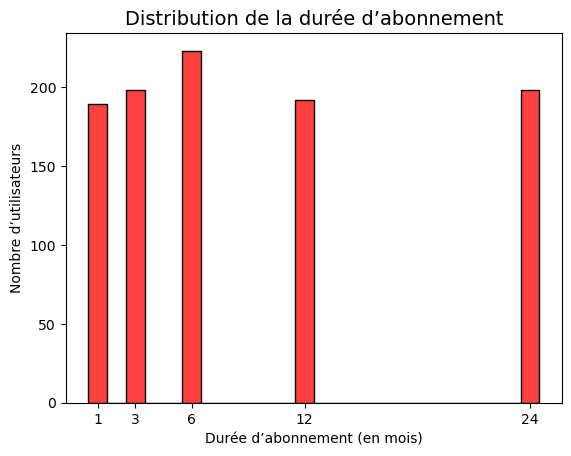

In [145]:
# Graphique représentant la distribution de l'ancienneté (la durée d'abonnement) :

sns.histplot(netflix["subscription_length_months"], bins=30, color="red",edgecolor="black", discrete=True)

plt.title("Distribution de la durée d’abonnement", fontsize=14)
plt.xlabel("Durée d’abonnement (en mois)")
plt.ylabel("Nombre d’utilisateurs")

plt.xticks(netflix["subscription_length_months"].unique())

plt.show()

# La durée d’abonnement prend un nombre limité de valeurs discrètes, correspondant sans doute à des offres standardisées. 
# On note une légère majoritée d'abonnements de 6 mois.

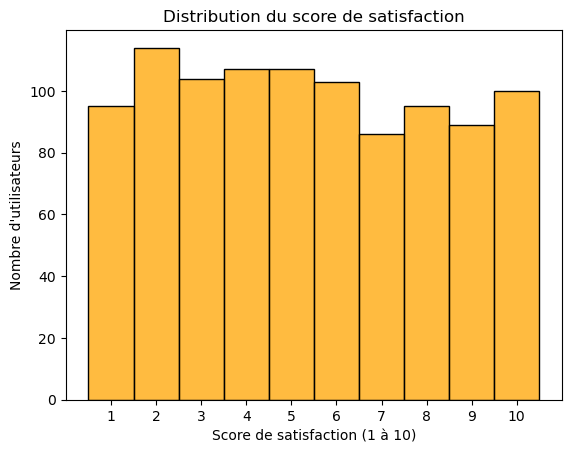

In [146]:
# Graphique représentant la distribution du score de satisfaction

sns.histplot(netflix["customer_satisfaction_score_1-10"], bins=10, color ='orange', discrete=True)
plt.title("Distribution du score de satisfaction")
plt.xlabel("Score de satisfaction (1 à 10)")
plt.ylabel("Nombre d'utilisateurs")
plt.xticks(netflix["customer_satisfaction_score_1-10"].unique())
plt.show()

# Globalement, les scores sont répartis de manière assez similaire (juste on peut voir un peu plus de notes de 2 et entre 3 et 6)

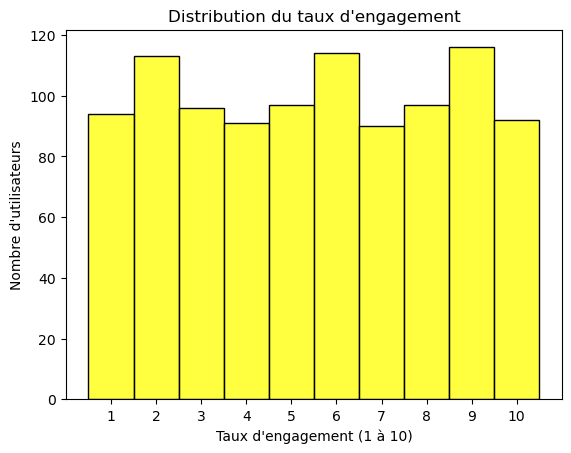

In [147]:
# Graphique représentant la distribution du taux d'engagement :

sns.histplot(netflix["engagement_rate_1-10"], bins=10, color ='yellow', discrete=True)
plt.title("Distribution du taux d'engagement")
plt.xlabel("Taux d'engagement (1 à 10)")
plt.ylabel("Nombre d'utilisateurs")
plt.xticks(netflix["engagement_rate_1-10"].unique())
plt.show()

# Globalement, les scores sont répartis de manière assez similaire, même si les valeurs 2, 6 et 9 ressortent plus que les autres.

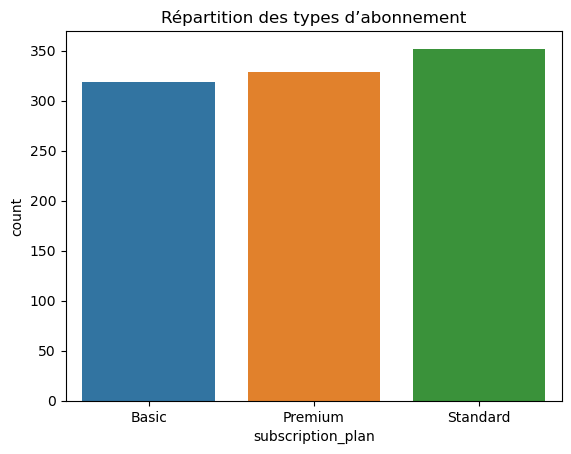

In [148]:
# Graphique représentant la distribution des différents abonnements :

sns.countplot(x="subscription_plan", data=netflix, hue="subscription_plan")
plt.title("Répartition des types d’abonnement")
plt.show()

# Il y a quasiment la même répartition entre les 3 abonnements existants (un peu plus d'abonnements standarts)

C:\Users\yanis\AppData\Local\Temp\ipykernel_20952\4008412688.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="churn", data=netflix, palette='viridis')


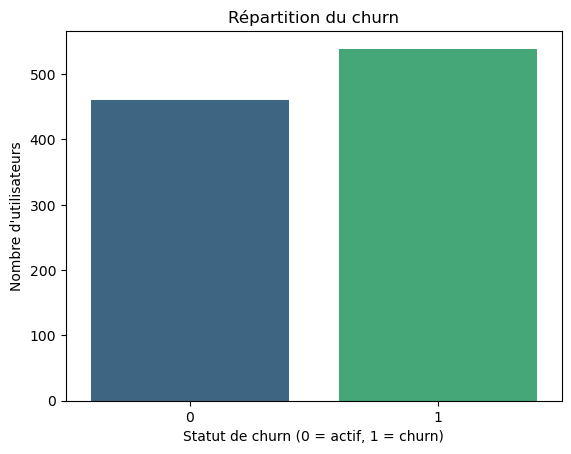

In [149]:
# Graphique représentant la distribution du churn

sns.countplot(x="churn", data=netflix, palette='viridis')
plt.title("Répartition du churn")
plt.xlabel("Statut de churn (0 = actif, 1 = churn)")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

# On voit quand même une majoritée de personne qui vont se désabonner (539 pour 461), ce qui est un enjeu majeur, d'ou l'importance de notre étude.

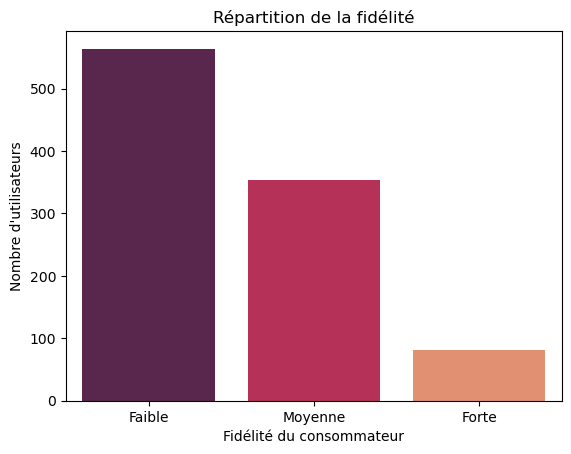

In [150]:
# # Graphique représentant la distribution des scores de fidélités :

sns.countplot(x="loyalty_category", data=netflix, hue='loyalty_category', palette='rocket')
plt.title("Répartition de la fidélité")
plt.xlabel("Fidélité du consommateur")
plt.ylabel("Nombre d'utilisateurs")
plt.show()

# Comme on le voit, on a très peu de consommateurs très fidèles (c'est a dire avec un taux d'engagement ainsi qu'un score de 
# satisfaction > ou = à 7 et une durée d'abonnement supérieure à 6) tandis qu'on a une majoritée de consommateurs très peu fidèles.

In [151]:
# 2) Analyse Bivariée :

,device_used_most_often,churn_rate,n,churn_rate_pct
1,Laptop,0.586667,225,58.7
2,Mobile,0.527363,201,52.7
4,Tablet,0.510000,200,51.0
3,Smart TV,0.497354,189,49.7
0,Desktop,0.567568,185,56.8


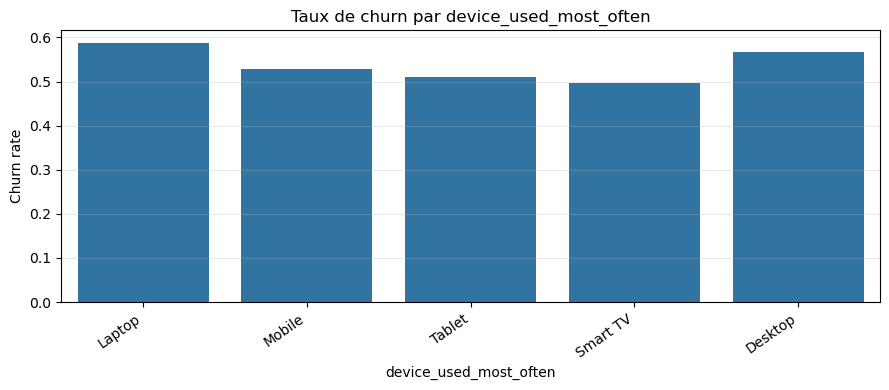

,genre_preference,churn_rate,n,churn_rate_pct
5,Sci-Fi,0.538922,167,53.9
3,Drama,0.555556,144,55.6
4,Romance,0.569444,144,56.9
6,Thriller,0.578571,140,57.9
2,Documentary,0.532374,139,53.2
0,Action,0.522059,136,52.2
1,Comedy,0.469231,130,46.9


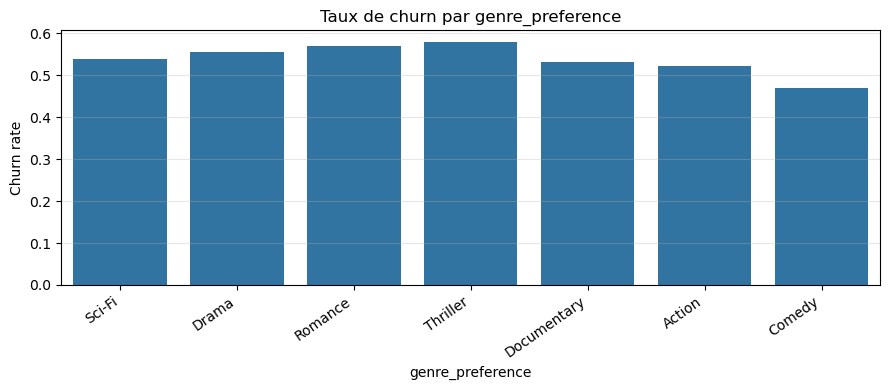

,region,churn_rate,n,churn_rate_pct
1,Asia,0.556098,205,55.6
0,Africa,0.556650,203,55.7
2,Europe,0.537313,201,53.7
4,South America,0.502488,201,50.2
3,North America,0.542105,190,54.2


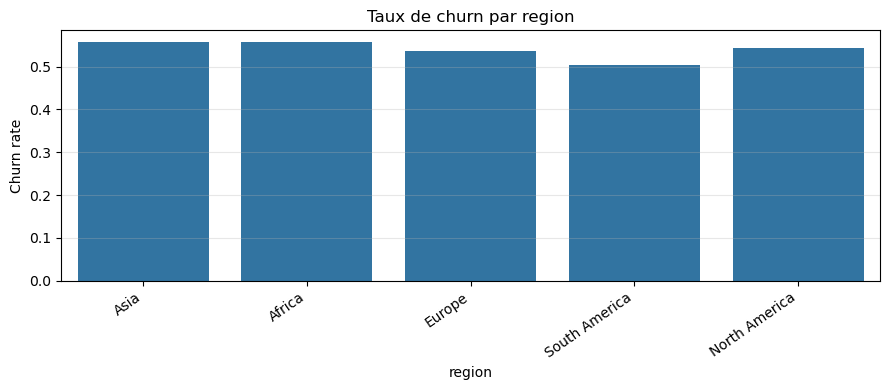

,payment_history_on-time/delayed,churn_rate,n,churn_rate_pct
0,Delayed,0.533203,512,53.3
1,On-Time,0.545082,488,54.5


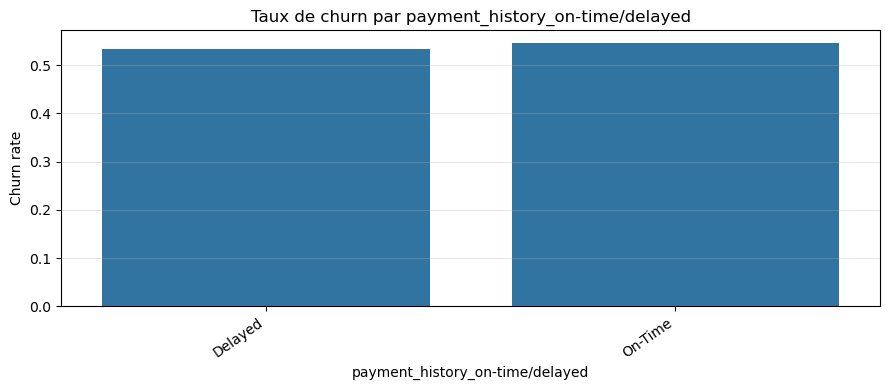

,subscription_plan,churn_rate,n,churn_rate_pct
2,Standard,0.534091,352,53.4
1,Premium,0.534954,329,53.5
0,Basic,0.548589,319,54.9


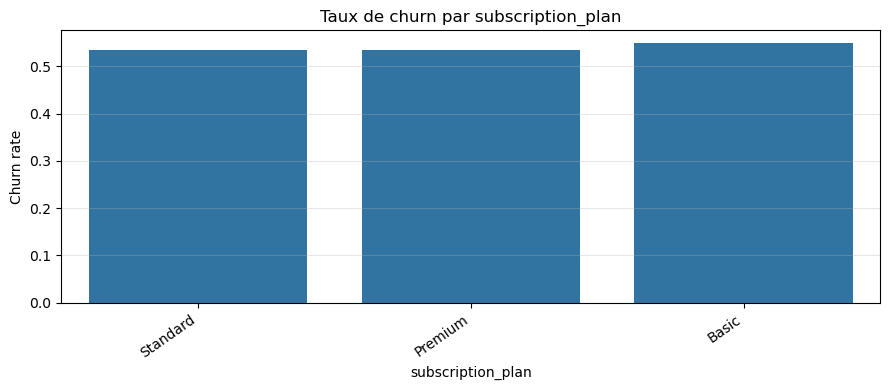

C:\Users\yanis\AppData\Local\Temp\ipykernel_26060\3670969559.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = (df.groupby(col)["churn"]


,loyalty_category,churn_rate,n,churn_rate_pct
0,Faible,0.521277,564,52.1
1,Moyenne,0.564972,354,56.5
2,Forte,0.548780,82,54.9


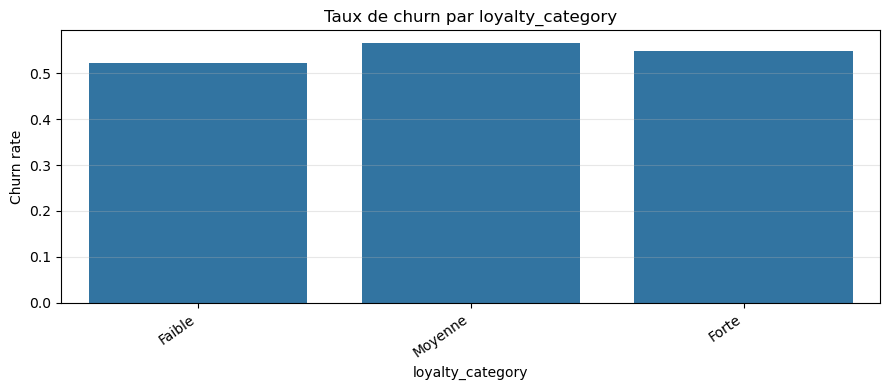

In [65]:
# Churn rate par variables catégorielles :

cat_cols = ['device_used_most_often', 'genre_preference', 'region', 'payment_history_on-time/delayed',
           'subscription_plan', 'loyalty_category']
cat_cols = [c for c in cat_cols if c is not None]  

def churn_by_category(df, col, top_n=15):
    tmp = (df.groupby(col)["churn"]
           .agg(churn_rate="mean", n="size")
           .reset_index()
          )
    # Va trier par effectif puis limiter le nombre (utile si trop de régions/genres)
    tmp = tmp.sort_values("n", ascending=False).head(top_n)
    tmp["churn_rate_pct"] = (tmp["churn_rate"] * 100).round(1)
    return tmp

for c in cat_cols:
    tmp = churn_by_category(netflix, c, top_n=15)
    display(tmp)  

    plt.figure(figsize=(9, 4))
    sns.barplot(data=tmp, x=c, y="churn_rate", errorbar=None)
    plt.title(f"Taux de churn par {c}")
    plt.xlabel(c)
    plt.ylabel("Churn rate")
    plt.xticks(rotation=35, ha="right")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
''' On remarque une majorité de désabonnements par les individus utilisant plus souvent des ordinnateurs, peut être parceque 
c'est plus simple de se désabonner à partir d'un pc.
Egalement, on remarque qu'en moyenne, il y a une proportion de churn pl
Sinon à part ca on ne voit pas apparaitre d'autres relations particulièrement interprétables pour les autres variables catégorielles.


C:\Users\yanis\AppData\Local\Temp\ipykernel_20952\2029314544.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="churn", y="customer_satisfaction_score_1-10", data=netflix, palette='deep')


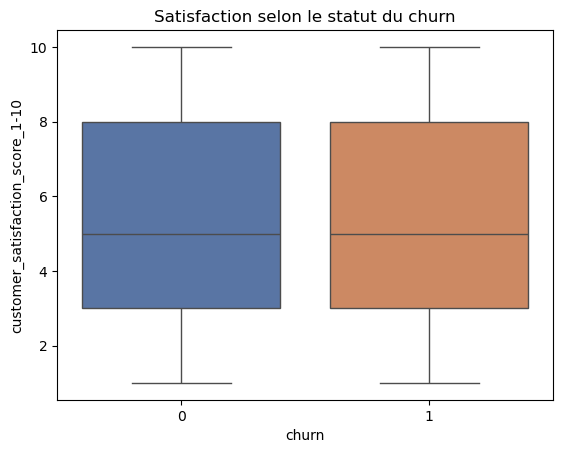

In [152]:
# Boxplot représentant la répartition des valeurs du score de satisfaction selon le statut du churn :

sns.boxplot(x="churn", y="customer_satisfaction_score_1-10", data=netflix, palette='deep')
plt.title("Satisfaction selon le statut du churn")
plt.show()

# On remarque que la distribution des scores de satisfaction est similaire, que les individus se soient déjà
# désabonnés une fois ou non.

# Cette variable, prise isolément, ne semble pas discriminante du churn dans ce jeu de données

C:\Users\yanis\AppData\Local\Temp\ipykernel_20952\3171804050.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="churn", y="engagement_rate_1-10", data=netflix, palette='mako')


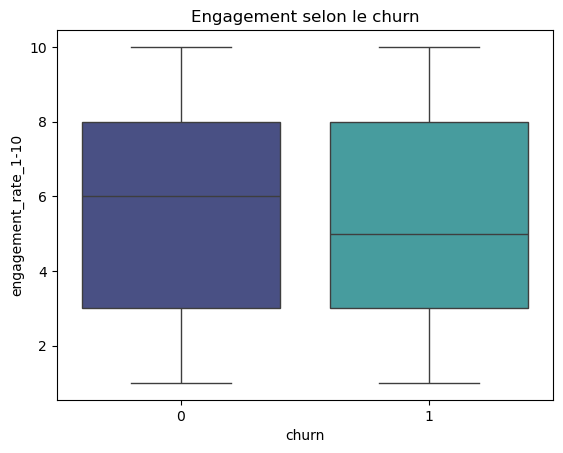

In [153]:
# Boxplot représentant la répartition des valeurs du score de satisfaction selon le statut du churn :

sns.boxplot(x="churn", y="engagement_rate_1-10", data=netflix, palette='mako')
plt.title("Engagement selon le churn")
plt.show()

# Les distributions du taux d’engagement sont globalement similaires entre utilisateurs churnés et non churnés, malgré une 
# médiane légèrement plus élevée chez les non-churnés.

C:\Users\yanis\AppData\Local\Temp\ipykernel_20952\2440921368.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="churn", y="subscription_length_months", data=netflix, palette='cubehelix')


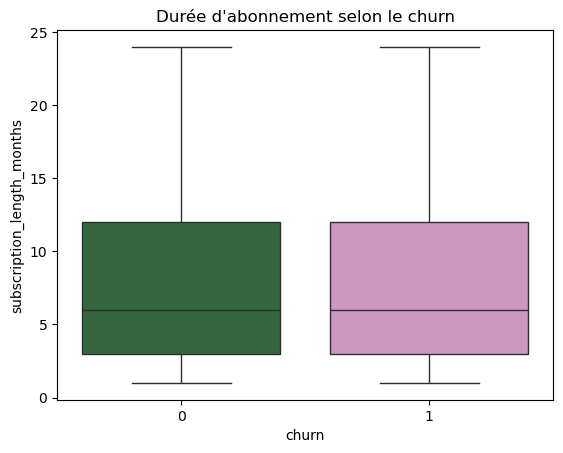

In [184]:
# Boxplot représentant la répartition des valeurs de la durée d'abonnement selon le statut du churn :

sns.boxplot(x="churn", y="subscription_length_months", data=netflix, palette='cubehelix')
plt.title("Durée d'abonnement selon le churn")
plt.show()

# L’ancienneté présente des distributions très proches selon le churn, ce qui ne met pas en évidence d’“early churn” clair sur ces données. 
# Cela indique que la durée d’abonnement seule ne discrimine pas fortement la résiliation.

Matrice de corrélation entre les variables quantitatives:

                                  subscription_length_months  customer_satisfaction_score_1-10  \
subscription_length_months                          1.000000                          0.033980   
customer_satisfaction_score_1-10                    0.033980                          1.000000   
daily_watch_time_hours                              0.009415                         -0.032284   
engagement_rate_1-10                               -0.048498                         -0.072081   
support_queries_logged                             -0.019271                          0.052658   
age                                                 0.044918                         -0.007904   
monthly_income_$                                   -0.030062                          0.020227   
promotional_offers_used                             0.035056                          0.003954   
number_of_profiles_created                          0.03518

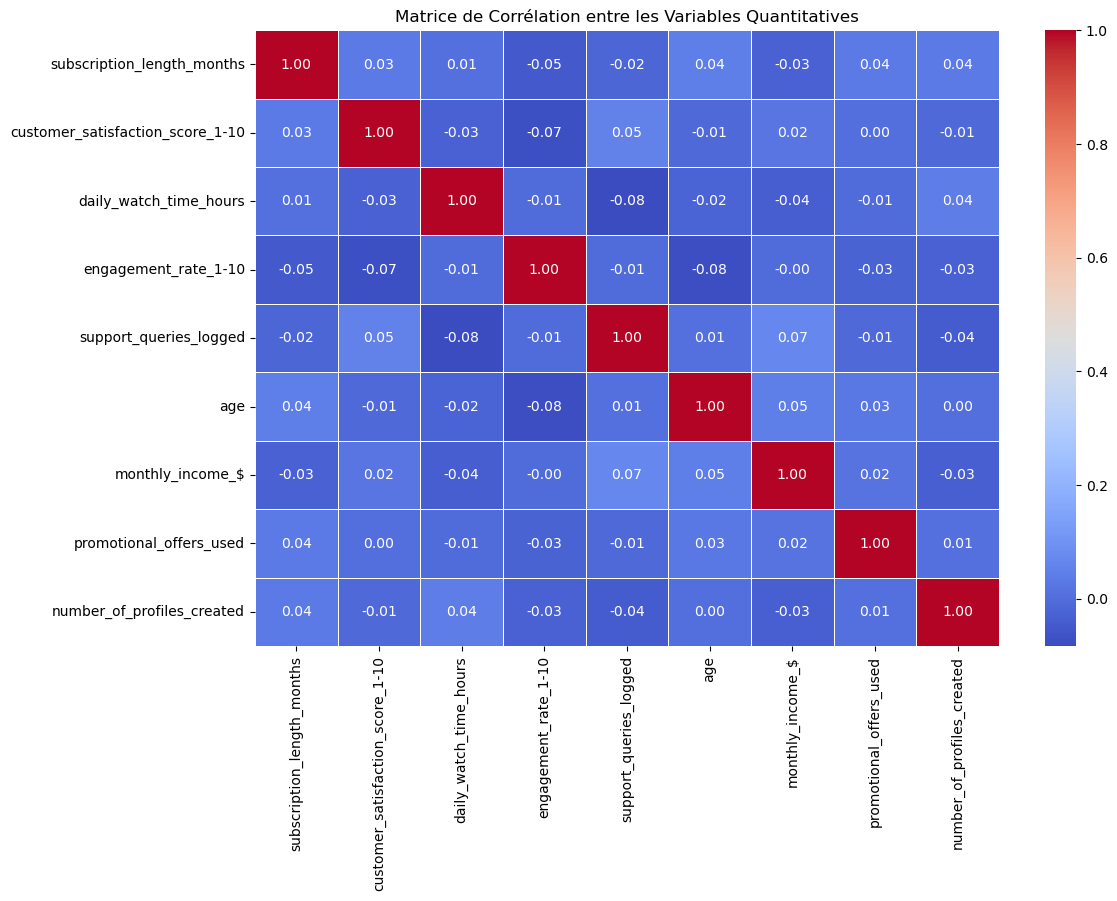

In [24]:
# Calculer les coefficients de corrélation entre les variables quantitatives

# On enlève les variables qualitatives de la base pour ne garder que les quantitatives :
netflix_num = netflix.drop(['customer_id', 'churn', 'loyalty_score', 'loyalty_category', 'device_used_most_often', 
                            'genre_preference', 'region', 'payment_history_on-time/delayed', 'subscription_plan', 
                            'churn_status_yes/no'], axis=1)
correlation_matrix = netflix_num.corr()

# Afficher la matrice de corrélation
# Ajuster la largeur d'affichage de pandas
pd.set_option('display.width', 100)
print("Matrice de corrélation entre les variables quantitatives:\n")
print(correlation_matrix)


## Créer un heatmap avec Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation entre les Variables Quantitatives')
plt.show()

In [ ]:
# On voit très peu de liens de corrélations entre les variables quantitatives de nos données.

In [ ]:
# Partie 2 : ACP

In [ ]:
''' Le score de fidélité n’est pas inclus dans l’analyse en composantes principales, car il est construit à partir de plusieurs 
variables déjà présentes dans l’ACP. 
Il sera utilisé a posteriori pour interpréter les axes et caractériser les profils d’utilisateurs.

In [156]:
netflix_num.head()

,subscription_length_months,customer_satisfaction_score_1-10,daily_watch_time_hours,engagement_rate_1-10,support_queries_logged,age,monthly_income_$,promotional_offers_used,number_of_profiles_created
0,12,10,4.85,4,10,33,6250,5,2
1,12,8,1.75,9,9,28,7018,1,5
2,3,4,2.75,9,3,18,1055,1,5
3,3,7,3.00,9,5,32,6707,5,4
4,24,2,1.37,5,2,59,1506,3,5


In [25]:
# Standardiser les données numériques pour mettre à la même échelle chaque variable
scaler = StandardScaler()
netflix_normaliser = scaler.fit_transform(netflix_num)
netflix_normaliser

array([[ 0.34366146,  1.61853076,  1.55187965, ...,  0.36718096,
         1.52656235, -0.6555444 ],
       [ 0.34366146,  0.91801972, -0.8290342 , ...,  0.64958599,
        -0.84203711,  1.44331708],
       [-0.75196488, -0.48300236, -0.06099748, ..., -1.54309786,
        -0.84203711,  1.44331708],
       ...,
       [-0.3867561 , -1.18351341, -0.3605318 , ..., -1.71886557,
         0.93441249, -1.35516489],
       [-0.75196488,  0.21750868, -0.84439494, ..., -0.57637543,
        -1.43418697,  0.74369658],
       [-0.9954374 ,  0.21750868, -0.68310723, ..., -0.81943497,
        -0.24988724,  0.74369658]])

In [26]:
# Appliquer l'ACP
pca = PCA()
principal_components = pca.fit_transform(netflix_normaliser)
print('Nombre de composantes calculées : ', principal_components.shape)

Nombre de composantes calculées :  (1000, 9)


In [27]:
# Analyse des composantes principales
composantes = pd.DataFrame(
    {
        "Dimension" : [f"Axe {i}" for i in range(1,10)],
        "Valeur propre" : pca.explained_variance_,

        "% variance expliquée" : np.round( pca.explained_variance_ratio_ * 100),
        "% cumulé variance expliquée" : np.round(np.cumsum( pca.explained_variance_ratio_) * 100)
    }
)

# Afficher les informations sur les composantes principales

print(composantes)

  Dimension  Valeur propre  % variance expliquée  % cumulé variance expliquée
0     Axe 1       1.191354                  13.0                         13.0
1     Axe 2       1.160915                  13.0                         26.0
2     Axe 3       1.029306                  11.0                         38.0
3     Axe 4       0.988237                  11.0                         49.0
4     Axe 5       0.966682                  11.0                         59.0
5     Axe 6       0.961830                  11.0                         70.0
6     Axe 7       0.933774                  10.0                         80.0
7     Axe 8       0.904098                  10.0                         90.0
8     Axe 9       0.872813                  10.0                        100.0


Nombre de variables numériques utilisées : 9


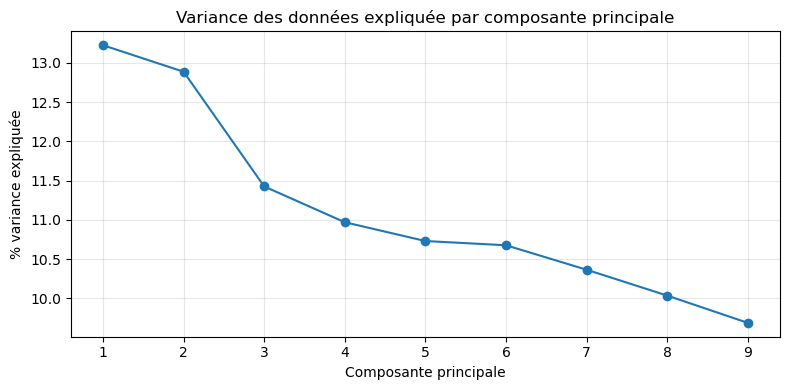

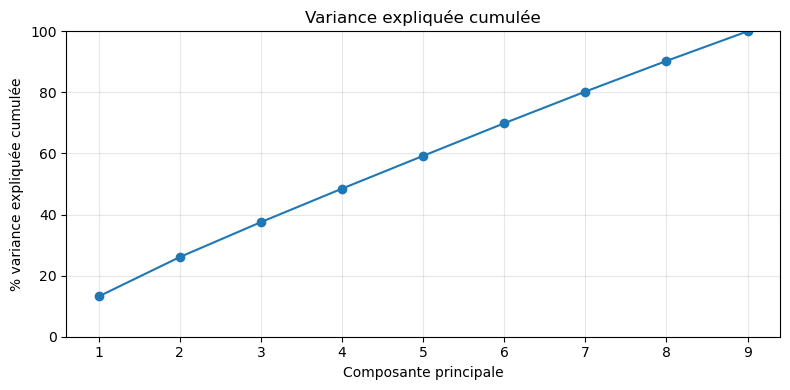

In [88]:
# Affichage du nombre de variables numériques et constructions de variables pythons :

features = netflix_num.columns.tolist()
n_features = len(features)
print("Nombre de variables numériques utilisées :", n_features)

explained_var_ratio = pca.explained_variance_ratio_
explained_var_ratio_pct = explained_var_ratio * 100
cum_explained_var_pct = np.cumsum(explained_var_ratio_pct)

# Visualisation graphique des composantes principales

plt.figure(figsize=(8, 4))
plt.plot(range(1, n_features + 1), explained_var_ratio_pct, marker="o")
plt.title("Variance des données expliquée par composante principale")
plt.xlabel("Composante principale")
plt.ylabel("% variance expliquée")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, n_features + 1), cum_explained_var_pct, marker="o")
plt.title("Variance expliquée cumulée")
plt.xlabel("Composante principale")
plt.ylabel("% variance expliquée cumulée")
plt.ylim(0, 100)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [87]:
''' La variance étant relativement répartie entre les différentes composantes, aucun axe ne domine fortement la structure des 
données (c'est assez conrant dans les données et études comportementales). 
Dans une optique d’analyse exploratoire et de visualisation, on va se concentrer sur les deux premières composantes principales, 
pour avoir une lecture synthétique des profils d’utilisateurs sans avoir à faire plusieurs graphiques complexifiant la lecture et l'interprétation
et qui n'appoterait pas forcément d'éléments supplémentaires.
Ceci représentera 26% de la variance expliquée.

_IncompleteInputError: incomplete input (1520477019.py, line 1)

In [31]:
# On refait l'analyse avec 2 composantes

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(netflix_normaliser)

print("Variance expliquée (PC1, PC2) :", np.round(pca2.explained_variance_ratio_ * 100, 2))
print("Variance cumulée (2 axes) :", np.round(pca2.explained_variance_ratio_.sum() * 100, 2), "%")


Variance expliquée (PC1, PC2) : [13.22 12.89]
Variance cumulée (2 axes) : 26.11 %


In [32]:
# On met les coordonnées des individus dans un DataFrame

df_pca = pd.DataFrame(X_pca2, columns=["PC1", "PC2"], index=netflix.index)

# On ajoute des infos utiles pour interpréter APRES avoir appliqué l'ACP
df_pca["churn"] = netflix["churn"]
df_pca["loyalty_score"] = netflix["loyalty_score"]
df_pca["loyalty_category"] = netflix["loyalty_category"]

print(" DataFrame avec les composantes principales:")
df_pca.head(10)

 DataFrame avec les composantes principales:


,PC1,PC2,churn,loyalty_score,loyalty_category
0,1.109157,-0.621714,0,2,Moyenne
1,0.706663,0.884351,1,3,Forte
2,-2.295562,1.237590,1,1,Faible
3,-0.139011,0.585579,0,2,Moyenne
4,-1.066607,-1.876336,1,1,Faible
5,0.148060,-1.004758,1,0,Faible
6,-0.391109,-0.011561,0,1,Faible
7,-0.254489,-1.212792,1,1,Faible
8,-0.033565,-0.603616,1,2,Moyenne
9,-0.192873,0.338069,0,0,Faible


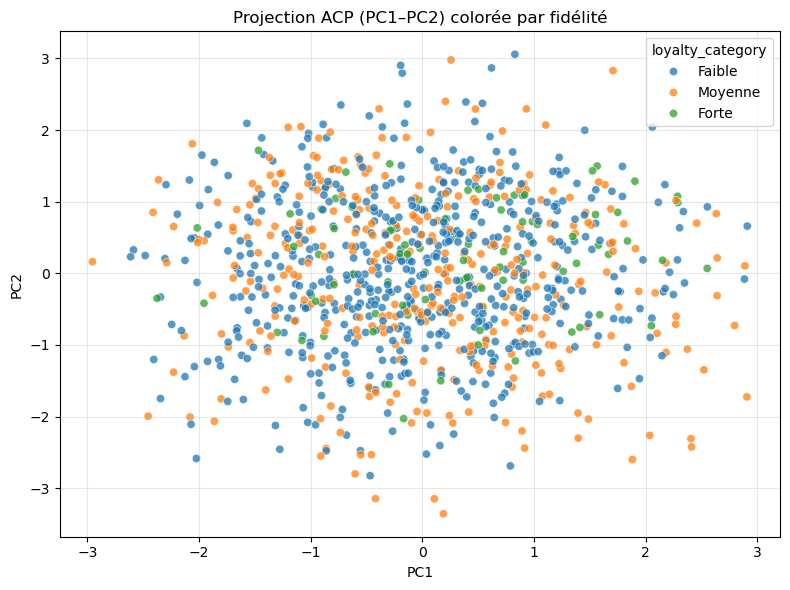

In [33]:
# On va vérifier si il y a une relation visible dans la répartition des individus sur les 2 premières composantes par rapport 
# d'une part à la fidélité, et d'autre part au churn

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="loyalty_category", alpha=0.75)
plt.title("Projection ACP (PC1–PC2) colorée par score de fidélité")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

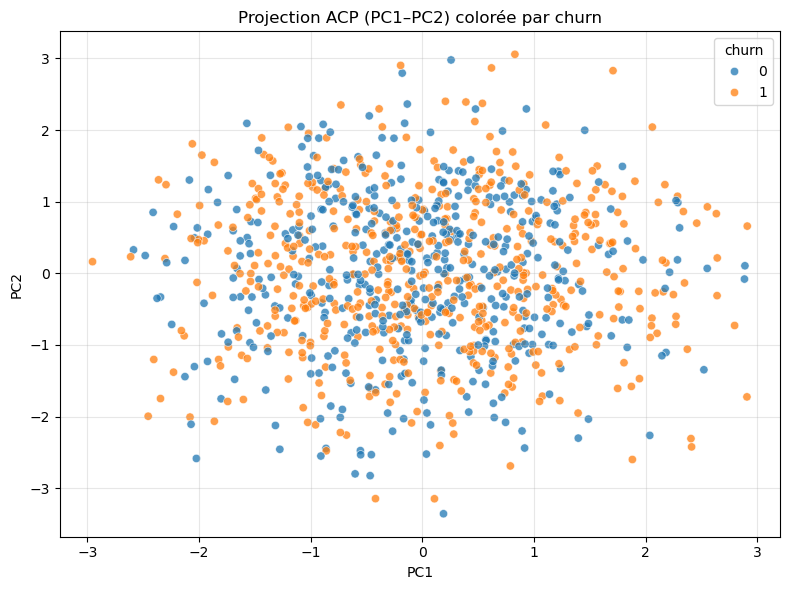

In [166]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="churn", alpha=0.75)
plt.title("Projection ACP (PC1–PC2) colorée par churn")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
''' La projection des individus sur le plan des deux premières composantes principales ne met pas en évidence de séparation nette 
entre les utilisateurs selon leur niveau de fidélité ou leur statut de churn. 

Cette observation suggère que la fidélité et le churn résultent de mécanismes multidimensionnels complexes, qui ne peuvent être 
capturés par une simple séparation visuelle dans l’espace factoriel. 

Cette complexité justifie le recours à des méthodes de segmentation afin d’identifier des profils d’utilisateurs plus homogènes 
(CAH juste après).

In [42]:
# Calculer les coefficients de corrélation entre les variables originales et les composantes principales
correlation_avec_axes = pd.DataFrame(pca.components_.T, columns=[f"Axe {i}" for i in range(1,10)], index=netflix_num.columns)
pd.set_option('display.width', 1000)

# Afficher la matrice de corrélation avec les composantes principales
print("Matrice de Corrélation avec les Composantes Principales :\n", correlation_avec_axes)

Matrice de Corrélation avec les Composantes Principales :
                                      Axe 1     Axe 2     Axe 3     Axe 4     Axe 5     Axe 6     Axe 7     Axe 8     Axe 9
subscription_length_months        0.000256 -0.504801  0.098536  0.292544 -0.452686 -0.011439  0.628870  0.024274 -0.220821
customer_satisfaction_score_1-10  0.355650 -0.212232  0.621042  0.091666  0.278650 -0.170379  0.061759 -0.333827  0.460917
daily_watch_time_hours           -0.463355 -0.158179 -0.021211 -0.222068  0.492325 -0.330662  0.379435  0.421763  0.192201
engagement_rate_1-10             -0.217109  0.539321 -0.137316  0.288646 -0.168204  0.198613  0.402974 -0.153760  0.553222
support_queries_logged            0.526118  0.191493  0.176891 -0.010822 -0.035054  0.258289  0.113636  0.752170  0.092238
age                               0.254130 -0.382175 -0.513612 -0.358603 -0.291733 -0.106929 -0.081364  0.004118  0.542022
monthly_income_$                  0.441119  0.116411 -0.359579 -0.214435  0.4361

In [43]:
# On peut donc calculer le cosinus des variables sur les composantes principales

cosine_squared = pca.components_ ** 2

cosine_df = pd.DataFrame(data=cosine_squared.T, columns=[f'Axe {i}' for i in range(1,10)])
cosine_df.index = netflix_num.columns
print("Cosinus carrés des variables sur les composantes principales:\n", cosine_df)

Cosinus carrés des variables sur les composantes principales:
                                          Axe 1     Axe 2     Axe 3     Axe 4     Axe 5     Axe 6     Axe 7     Axe 8     Axe 9
subscription_length_months        6.572070e-08  0.254824  0.009709  0.085582  0.204925  0.000131  0.395477  0.000589  0.048762
customer_satisfaction_score_1-10  1.264871e-01  0.045043  0.385693  0.008403  0.077646  0.029029  0.003814  0.111441  0.212445
daily_watch_time_hours            2.146980e-01  0.025020  0.000450  0.049314  0.242384  0.109338  0.143971  0.177884  0.036941
engagement_rate_1-10              4.713627e-02  0.290867  0.018856  0.083316  0.028293  0.039447  0.162388  0.023642  0.306054
support_queries_logged            2.768003e-01  0.036670  0.031290  0.000117  0.001229  0.066713  0.012913  0.565759  0.008508
age                               6.458209e-02  0.146058  0.263797  0.128596  0.085108  0.011434  0.006620  0.000017  0.293788
monthly_income_$                  1.945855e-01  

In [47]:
# On va afficher Les loadings = poids des variables dans chaque composante, par ordre décroissant

loadings = pd.DataFrame(
    pca2.components_.T,
    index= features,
    columns=["PC1", "PC2"]
)

top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(9)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(9)

print("Top variables (|loading|) PC1 :\n", top_pc1)
print("\nTop variables (|loading|) PC2 :\n", top_pc2)

Top variables (|loading|) PC1 :
 support_queries_logged              0.526118
daily_watch_time_hours              0.463355
monthly_income_$                    0.441119
customer_satisfaction_score_1-10    0.355650
number_of_profiles_created          0.261625
age                                 0.254130
engagement_rate_1-10                0.217109
promotional_offers_used             0.085223
subscription_length_months          0.000256
Name: PC1, dtype: float64

Top variables (|loading|) PC2 :
 engagement_rate_1-10                0.539321
subscription_length_months          0.504801
age                                 0.382175
number_of_profiles_created          0.335660
promotional_offers_used             0.274407
customer_satisfaction_score_1-10    0.212232
support_queries_logged              0.191493
daily_watch_time_hours              0.158179
monthly_income_$                    0.116411
Name: PC2, dtype: float64


In [170]:
'''Interprétation : Si cos2 élevé, alors variable bien représentée par la composante principale
(forte correlation entre une variable i initial et la composante principale K)

Ici, pour l'axe 1, d'après les cos2 et les loadings, les variables qui contribuent le plus à l'axe sont les demandes de supports 
clients, le temps de visionnage journalier et le revenu mensuel

Pour l'axe 2, avec le même raisonnement les variables qui contribuent le plus à l'axe sont le taux d'engagement, le nombre de mois
de souscription et l'age.

_IncompleteInputError: incomplete input (1326255024.py, line 1)

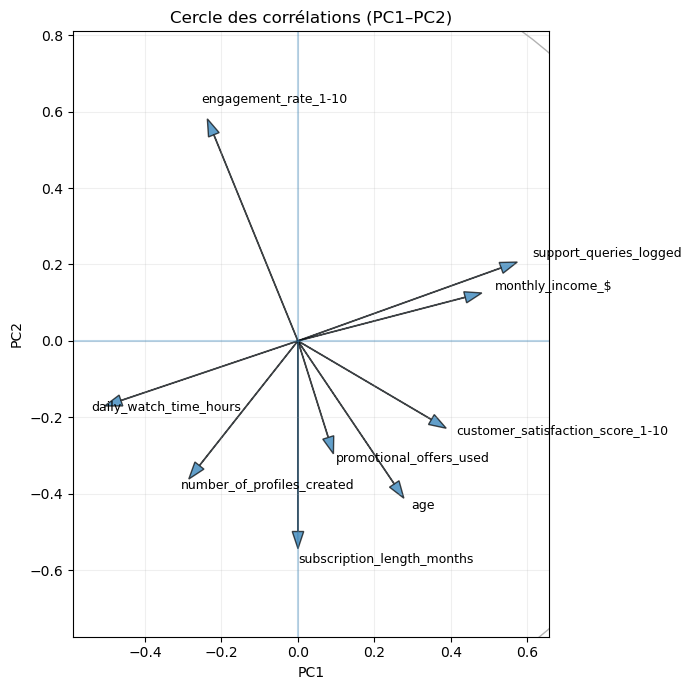

In [49]:
# Réalisation du cercle de corrélation :

eigvals = pca2.explained_variance_
coords = loadings.copy()
# En PCA sur données standardisées, les loadings peuvent être interprétés comme des corrélations si on les ajuste avec 
# la racine des valeurs propres.
coords["PC1"] = coords["PC1"] * np.sqrt(eigvals[0])
coords["PC2"] = coords["PC2"] * np.sqrt(eigvals[1])

plt.figure(figsize=(7, 7))
plt.axhline(0, alpha=0.3)
plt.axvline(0, alpha=0.3)

for var in features:
    plt.arrow(0, 0, coords.loc[var, "PC1"], coords.loc[var, "PC2"], alpha=0.7, head_width=0.03, length_includes_head=True)
    plt.text(coords.loc[var, "PC1"] * 1.07, coords.loc[var, "PC2"] * 1.07, var, fontsize=9)

circle = plt.Circle((0, 0), 1, fill=False, alpha=0.3)
plt.gca().add_artist(circle)

plt.title("Cercle des corrélations (PC1–PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.2)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [ ]:
''' Interprétation Cercle :

Avec les loadings et les cos2, on avait un apercu de la contributions de chaque variable à chaque axe, mais pas le sens des
contributions. Grace au cercle, on va pouvoir voir quelles variables sont corrélées et lesquelles sont opposées.

Concernant la première composante principale (Axe 1), on observe une contribution positive marquée du revenu mensuel, du score 
de satisfaction client et du nombre de demandes adressées au support client. 
À l’inverse, le temps de visionnage quotidien contribue négativement à cet axe.

L’axe 1 semble ainsi opposer des profils disposant d’un revenu plus élevé, globalement plus satisfaits et davantage en 
interaction avec le support client, à des profils caractérisés par un usage intensif du service en termes de temps de visionnage.
Cette opposition peut suggérer que certains utilisateurs, potentiellement plus aisés, entretiennent une relation différente 
avec la plateforme, marquée par une satisfaction élevée mais un usage moins intensif du contenu, tout en étant plus enclins 
à solliciter le support en cas de besoin.

L'Axe 2 est principalement structurée par le taux d’engagement, qui contribue fortement et positivement à l’axe, tandis que 
la durée d’abonnement (ancienneté) contribue de manière négative. 

L’axe 2 semble ainsi opposer des utilisateurs très engagés, souvent plus récents, à des utilisateurs abonnés depuis plus 
longtemps. 
Cette structure est cohérente avec l’hypothèse d’un engagement plus fort au début de l’abonnement, lié à la découverte de la 
plateforme et de son catalogue, suivi d’une possible diminution de l’intensité d’usage au fil du temps, traduisant une forme 
d’utilité marginale décroissante du contenu.

Enfin, certaines variables telles que le nombre de profils créés ou l’âge contribuent de manière plus modérée aux deux premières 
composantes. Elles ne structurent pas un axe en particulier mais reflètent des caractéristiques transversales du comportement 
des utilisateurs (varient différamment pour chaque individu sans définir clairement une des deux composantes).


In [ ]:
# Partie 3 : Segmentation via CAH et k-means

In [ ]:
# Comme vu précédamment, comme il n’existe pas de séparation naturelle évidente, on va chercher des groupes homogènes à l’aide 
# d’une classification hiérarchique =) CAH qui va regrouper progressivement les individus les plus proches les uns des autres,
# jusqu’à ce qu’il ne reste qu’un seul groupe.

In [ ]:
''' La classification ascendante hiérarchique permet d’identifier des groupes d’utilisateurs présentant des comportements 
homogènes. Contrairement à l’ACP, qui fournit une vision continue des profils, la CAH permet de structurer la population en 
segments exploitables d’un point de vue opérationnel.
Ces segments présentent des niveaux de fidélité et de churn distincts, ouvrant la voie à des actions fidélisantes ciblées. 

On va réaliser une CAH a partir des données de l'ACP.
Pourquoi ? Parce que les données sont déjà normalisées (obligatoire) et que les axes ne sont pas corrélés entre eux et 
synthétises bien l'information et la variance des données.

In [50]:
# Application CAH
CAH_ward = linkage(df_pca[["PC1", "PC2"]], method='ward')

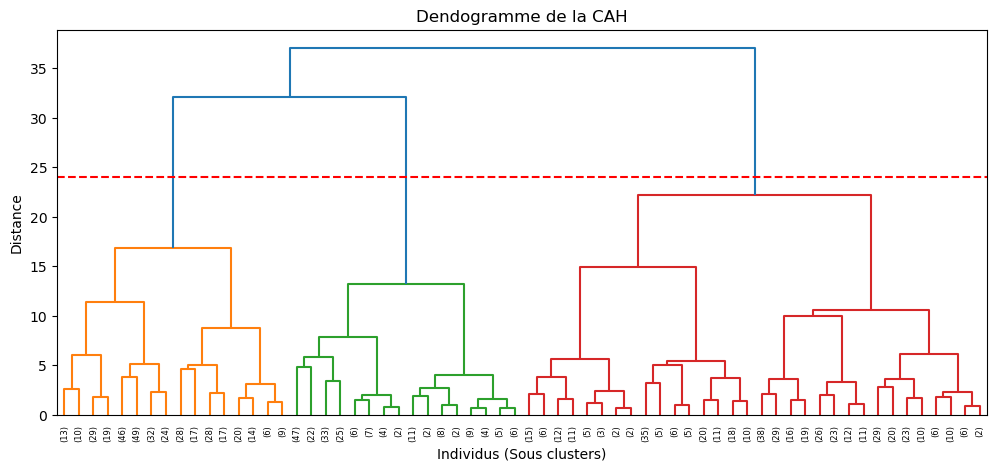

In [51]:
# Réalisation Dendogramme CAH :
plt.figure(figsize=(12, 5))

# On utilise truncate et p=5 pour afficher les derniers niveaux de l'arbre (voir les grands groupes se définir et se rejoindre
# sans être noyé dans l'information
dendrogram(CAH_ward, labels = netflix.index, orientation ='top', distance_sort='descending', show_leaf_counts=True, 
           truncate_mode="level",p=5)
plt.axhline(y= 24, color='red', linestyle='--')
plt.xticks(rotation = 90)
plt.title("Dendogramme de la CAH")
plt.xlabel('Individus (Sous clusters)')
plt.ylabel('Distance')
plt.show()

In [ ]:
# On voit clairement se dessiner 3 groupes de consommateurs homogènes =) on selectionnera 3 clusters

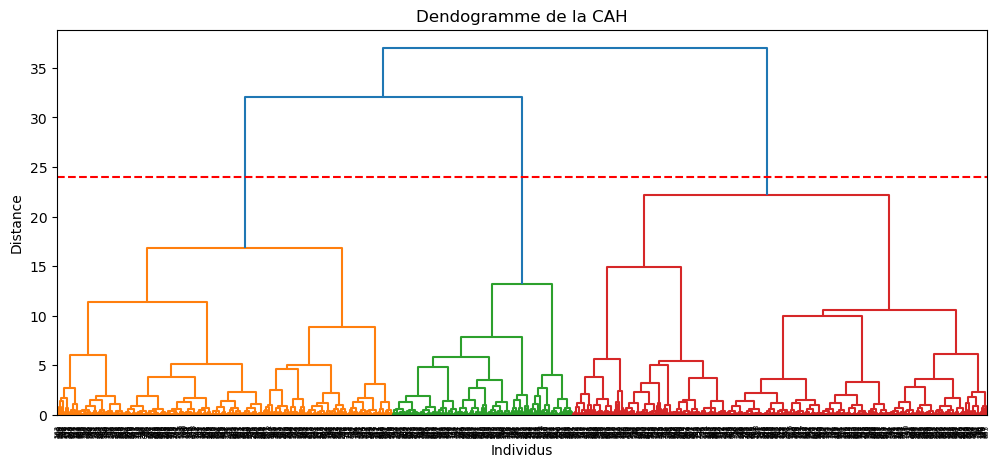

In [52]:
# Pour comparer, voici l'arbre complet :
plt.figure(figsize=(12, 5))
dendrogram(CAH_ward, labels = netflix.index, orientation ='top', distance_sort='descending', show_leaf_counts=True)
plt.axhline(y= 24, color='red', linestyle='--')
plt.xticks(rotation = 90)
plt.title("Dendogramme de la CAH")
plt.xlabel('Individus')
plt.ylabel('Distance')
plt.show()

In [53]:
# On rajoute a notre dataset avec les valeurs de l'ACP l'appartenance aux clusters pour chaque individu (Segmentation)

df_pca["cluster_cah"] = fcluster(CAH_ward,
                                 t=3, criterion="maxclust"
                                )
df_pca.head()

,PC1,PC2,churn,loyalty_score,loyalty_category,cluster_cah
0,1.109157,-0.621714,0,2,Moyenne,1
1,0.706663,0.884351,1,3,Forte,1
2,-2.295562,1.237590,1,1,Faible,3
3,-0.139011,0.585579,0,2,Moyenne,3
4,-1.066607,-1.876336,1,1,Faible,2


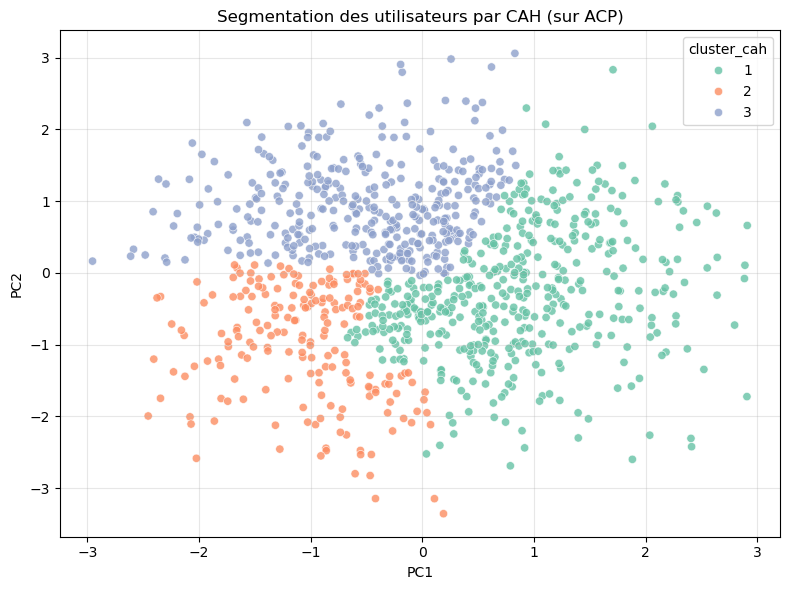

In [54]:
# Visualisation des clusters sur le plan de l'ACP pour visualiser le résultat de la segmentation

plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="cluster_cah",
    palette="Set2",
    alpha=0.8
)

plt.title("Segmentation des utilisateurs par CAH (sur ACP)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
''' On voit bien apparaitre les 3 clusters distinctement dans le graph de l'ACP, on peut déjà interpréter à partir de ca et
du cercle de corrélation de l'ACP, mais pour être plus précis et avoir plus d'infos, on va réaliser d'autres opérations.

In [55]:
# Calcul churn moyen pour chaque groupe
print('Churn moyen par cluster :')
df_pca.groupby("cluster_cah")["churn"].mean()

Churn moyen par cluster :


cluster_cah
1    0.562780
2    0.523316
3    0.518006
Name: churn, dtype: float64

In [56]:
# Calcul du score de fidélité moyen pour chaque groupe
print('Score de fidélité moyen par cluster :')
df_pca.groupby("cluster_cah")["loyalty_score"].mean()

Score de fidélité moyen par cluster :


cluster_cah
1    1.464126
2    1.274611
3    1.326870
Name: loyalty_score, dtype: float64

In [57]:
# Calcul de la taille des groupes en % de la population de 1000 individus
print('Taille des clusters (en %) :')
df_pca["cluster_cah"].value_counts(normalize=True)

Taille des clusters (en %) :


cluster_cah
1    0.446
3    0.361
2    0.193
Name: proportion, dtype: float64

In [70]:
# On réalise un dataset qui regroupe pour chaque cluster nos résultats :

summary_clusters = (netflix.groupby("cluster_cah")
                    .agg(
                        n=("cluster_cah", "size"),
                        churn_rate=("churn", "mean"),
                        loyalty_mean=("loyalty_score", "mean")
                    )
                    .reset_index()
                   )

summary_clusters["Taille_cluster"] = (summary_clusters["n"] / summary_clusters["n"].sum() * 100).round(1)
summary_clusters["churn_rate_%"] = (summary_clusters["churn_rate"] * 100).round(1)
summary_clusters["fidélité_moyenne"] = summary_clusters["loyalty_mean"].round(2)

summary_clusters = summary_clusters.sort_values("cluster_cah")
summary_clusters

,cluster_cah,n,churn_rate,loyalty_mean,Taille_cluster,churn_rate_%,fidélité_moyenne
0,1,446,0.562780,1.464126,44.6,56.3,1.46
1,2,193,0.523316,1.274611,19.3,52.3,1.27
2,3,361,0.518006,1.326870,36.1,51.8,1.33


In [58]:
# On regroupe par clusters les valeurs moyennes pour chaque variable numérique à partir du dataset initial

netflix["cluster_cah"] = df_pca["cluster_cah"]
cluster_profile = netflix.groupby("cluster_cah").mean(numeric_only=True)
cluster_profile

,subscription_length_months,customer_satisfaction_score_1-10,daily_watch_time_hours,engagement_rate_1-10,support_queries_logged,age,monthly_income_$,promotional_offers_used,number_of_profiles_created,churn,loyalty_score
cluster_cah,,,,,,,,,,,
1,10.394619,6.479821,2.346547,4.473094,6.172646,48.766816,6202.968610,2.695067,2.807175,0.562780,1.464126
2,13.362694,4.927461,3.609896,4.487047,2.611399,44.927461,3614.025907,2.704663,3.860104,0.523316,1.274611
3,5.434903,4.260388,3.008726,7.340720,4.692521,37.171745,4951.304709,1.933518,2.603878,0.518006,1.326870


In [77]:
netflix.head()

,customer_id,subscription_length_months,customer_satisfaction_score_1-10,daily_watch_time_hours,engagement_rate_1-10,device_used_most_often,genre_preference,region,payment_history_on-time/delayed,subscription_plan,churn_status_yes/no,support_queries_logged,age,monthly_income_$,promotional_offers_used,number_of_profiles_created,churn,loyalty_score,loyalty_category,cluster_cah
0,C00001,12,10,4.85,4,Tablet,Action,Europe,On-Time,Basic,No,10,33,6250,5,2,0,2,Moyenne,1
1,C00002,12,8,1.75,9,Laptop,Thriller,Europe,On-Time,Basic,Yes,9,28,7018,1,5,1,3,Forte,1
2,C00003,3,4,2.75,9,Smart TV,Comedy,Asia,On-Time,Premium,Yes,3,18,1055,1,5,1,1,Faible,3
3,C00004,3,7,3.00,9,Smart TV,Drama,Europe,Delayed,Premium,No,5,32,6707,5,4,0,2,Moyenne,3
4,C00005,24,2,1.37,5,Mobile,Drama,North America,On-Time,Standard,Yes,2,59,1506,3,5,1,1,Faible,2


In [82]:
# Réprésentation des variables clés par cluster pour leur interprétation par plusieurs graphiques :

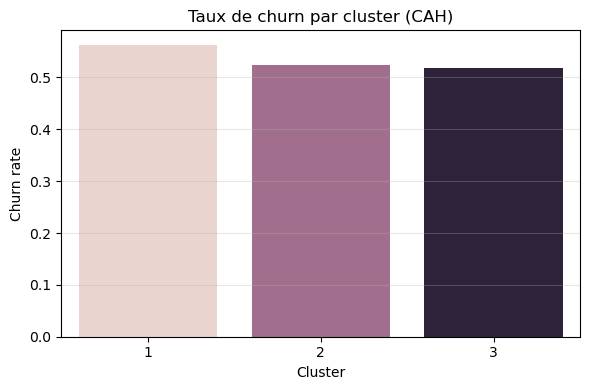

In [89]:
plt.figure(figsize=(6, 4))
sns.barplot(data=summary_clusters, x="cluster_cah", y="churn_rate", errorbar=None, hue='cluster_cah', legend=False)
plt.title("Taux de churn par cluster (CAH)")
plt.xlabel("Cluster")
plt.ylabel("Churn rate")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

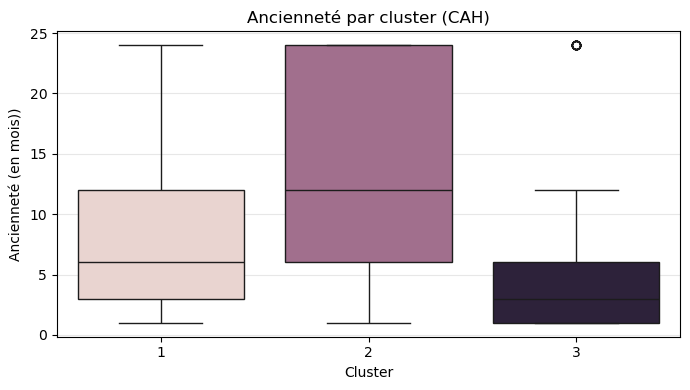

In [81]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=netflix, x="cluster_cah", y="subscription_length_months", hue ='cluster_cah', legend=False)
plt.title("Ancienneté par cluster (CAH)")
plt.xlabel("Cluster")
plt.ylabel("Ancienneté (en mois))")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

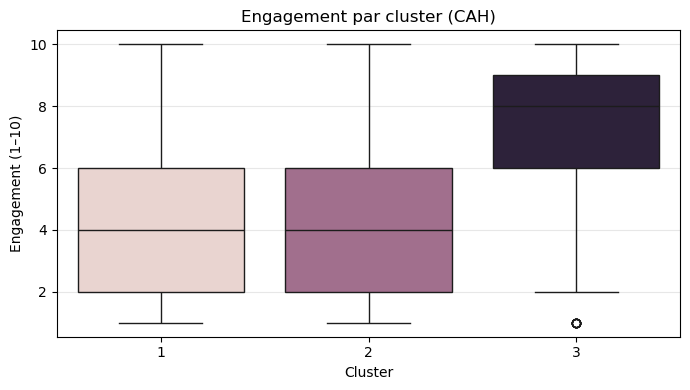

In [80]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=netflix, x="cluster_cah", y="engagement_rate_1-10", hue ='cluster_cah', legend=False)
plt.title("Engagement par cluster (CAH)")
plt.xlabel("Cluster")
plt.ylabel("Engagement (1–10)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

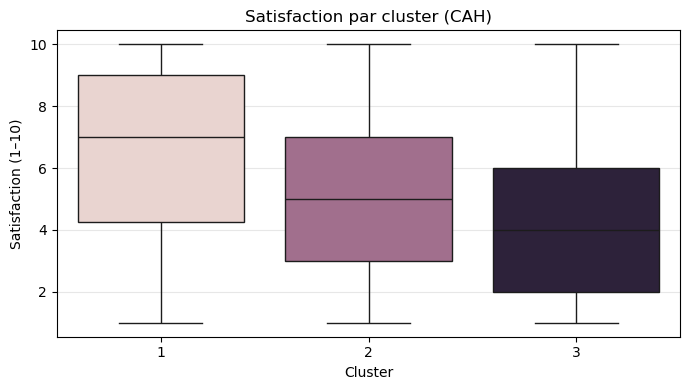

In [83]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=netflix, x="cluster_cah", y="customer_satisfaction_score_1-10", hue ='cluster_cah', legend=False)
plt.title("Satisfaction par cluster (CAH)")
plt.xlabel("Cluster")
plt.ylabel("Satisfaction (1–10)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
'''Interprétation clusters : 

Cluster 1 – Clients fortunés et exigeants à forte fidélité historique

Le premier cluster regroupe la majorité des utilisateurs (446 individus). Il présente le score de fidélité moyen le plus élevé, ainsi qu’un niveau de 
churn relativement important. Ce cluster est principalement positionné du côté positif de l’axe 1 de l’ACP, axe structuré par le revenu mensuel, 
le score de satisfaction et le nombre de requêtes adressées au support client.

Les utilisateurs de ce cluster se caractérisent par un niveau de revenu élevé, une satisfaction globale importante et une ancienneté moyenne relativement 
élevée (environ 10 mois). Leur taux d’engagement est modéré et leur temps de visionnage quotidien relativement faible, tandis que le recours au support 
client est fréquent. 

Ce profil peut correspondre à des utilisateurs exigeants, disposant d’un fort pouvoir d’achat, satisfaits du service mais attentifs à la qualité et au 
support, avec un usage plus sélectif du contenu.

Cluster 2 – Clients stables à engagement modéré et à usage familial

Le second cluster regroupe 361 individus et présente un score de fidélité et un taux de churn moyens inférieurs à ceux du premier cluster. 
Les utilisateurs de ce groupe disposent d’un revenu moyen plus faible, d’une ancienneté relativement élevée et d’un niveau de satisfaction intermédiaire.

Ils se distinguent par un faible recours au support client et par un nombre moyen de profils créés plus important, suggérant un usage plus collectif ou 
familial de la plateforme. Leur engagement et leur temps de visionnage restent modérés. 

Ce cluster correspond à des utilisateurs relativement stables, moins exigeants, avec une utilisation régulière mais peu intensive du service.

Cluster 3 – Nouveaux utilisateurs très engagés et à faible churn

Le troisième cluster est le plus restreint (193 individus) et présente le taux de churn moyen le plus faible, avec un score de fidélité intermédiaire 
entre les deux autres clusters. Ce groupe se distingue nettement par une ancienneté moyenne faible (environ 5 mois), un niveau d’engagement très élevé 
et un âge moyen plus faible.

Les utilisateurs de ce cluster affichent un score de satisfaction relativement plus faible, un recours limité aux offres promotionnelles et des valeurs 
intermédiaires en termes de revenu, de temps de visionnage et de recours au support client.

Ce profil semble correspondre à des utilisateurs récents, très engagés dans la découverte de la plateforme, pour lesquels l’intensité d’usage est forte 
malgré une satisfaction encore en construction.


In [ ]:
''' Pour résumer, La segmentation met en évidence trois profils d’utilisateurs aux comportements distincts, illustrant la 
diversité des parcours clients sur la plateforme. 
Ces résultats soulignent la nécessité d’adapter les stratégies de rétention aux caractéristiques spécifiques de chaque segment,
ce que l'on va prendre en compte pour les recommandations.